# PROJEKTNA NALOGA ORV - FACE ID

## Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os


## Train data set

In [11]:
#defining train data set
train_dir='captured_frames'
Train_Data=tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255.0,
).flow_from_directory(train_dir,batch_size=16,subset="training",target_size=(224,224),shuffle=False)
list(Train_Data.class_indices.keys())

Found 200 images belonging to 3 classes.


['daniela', 'viktor', 'ziga']

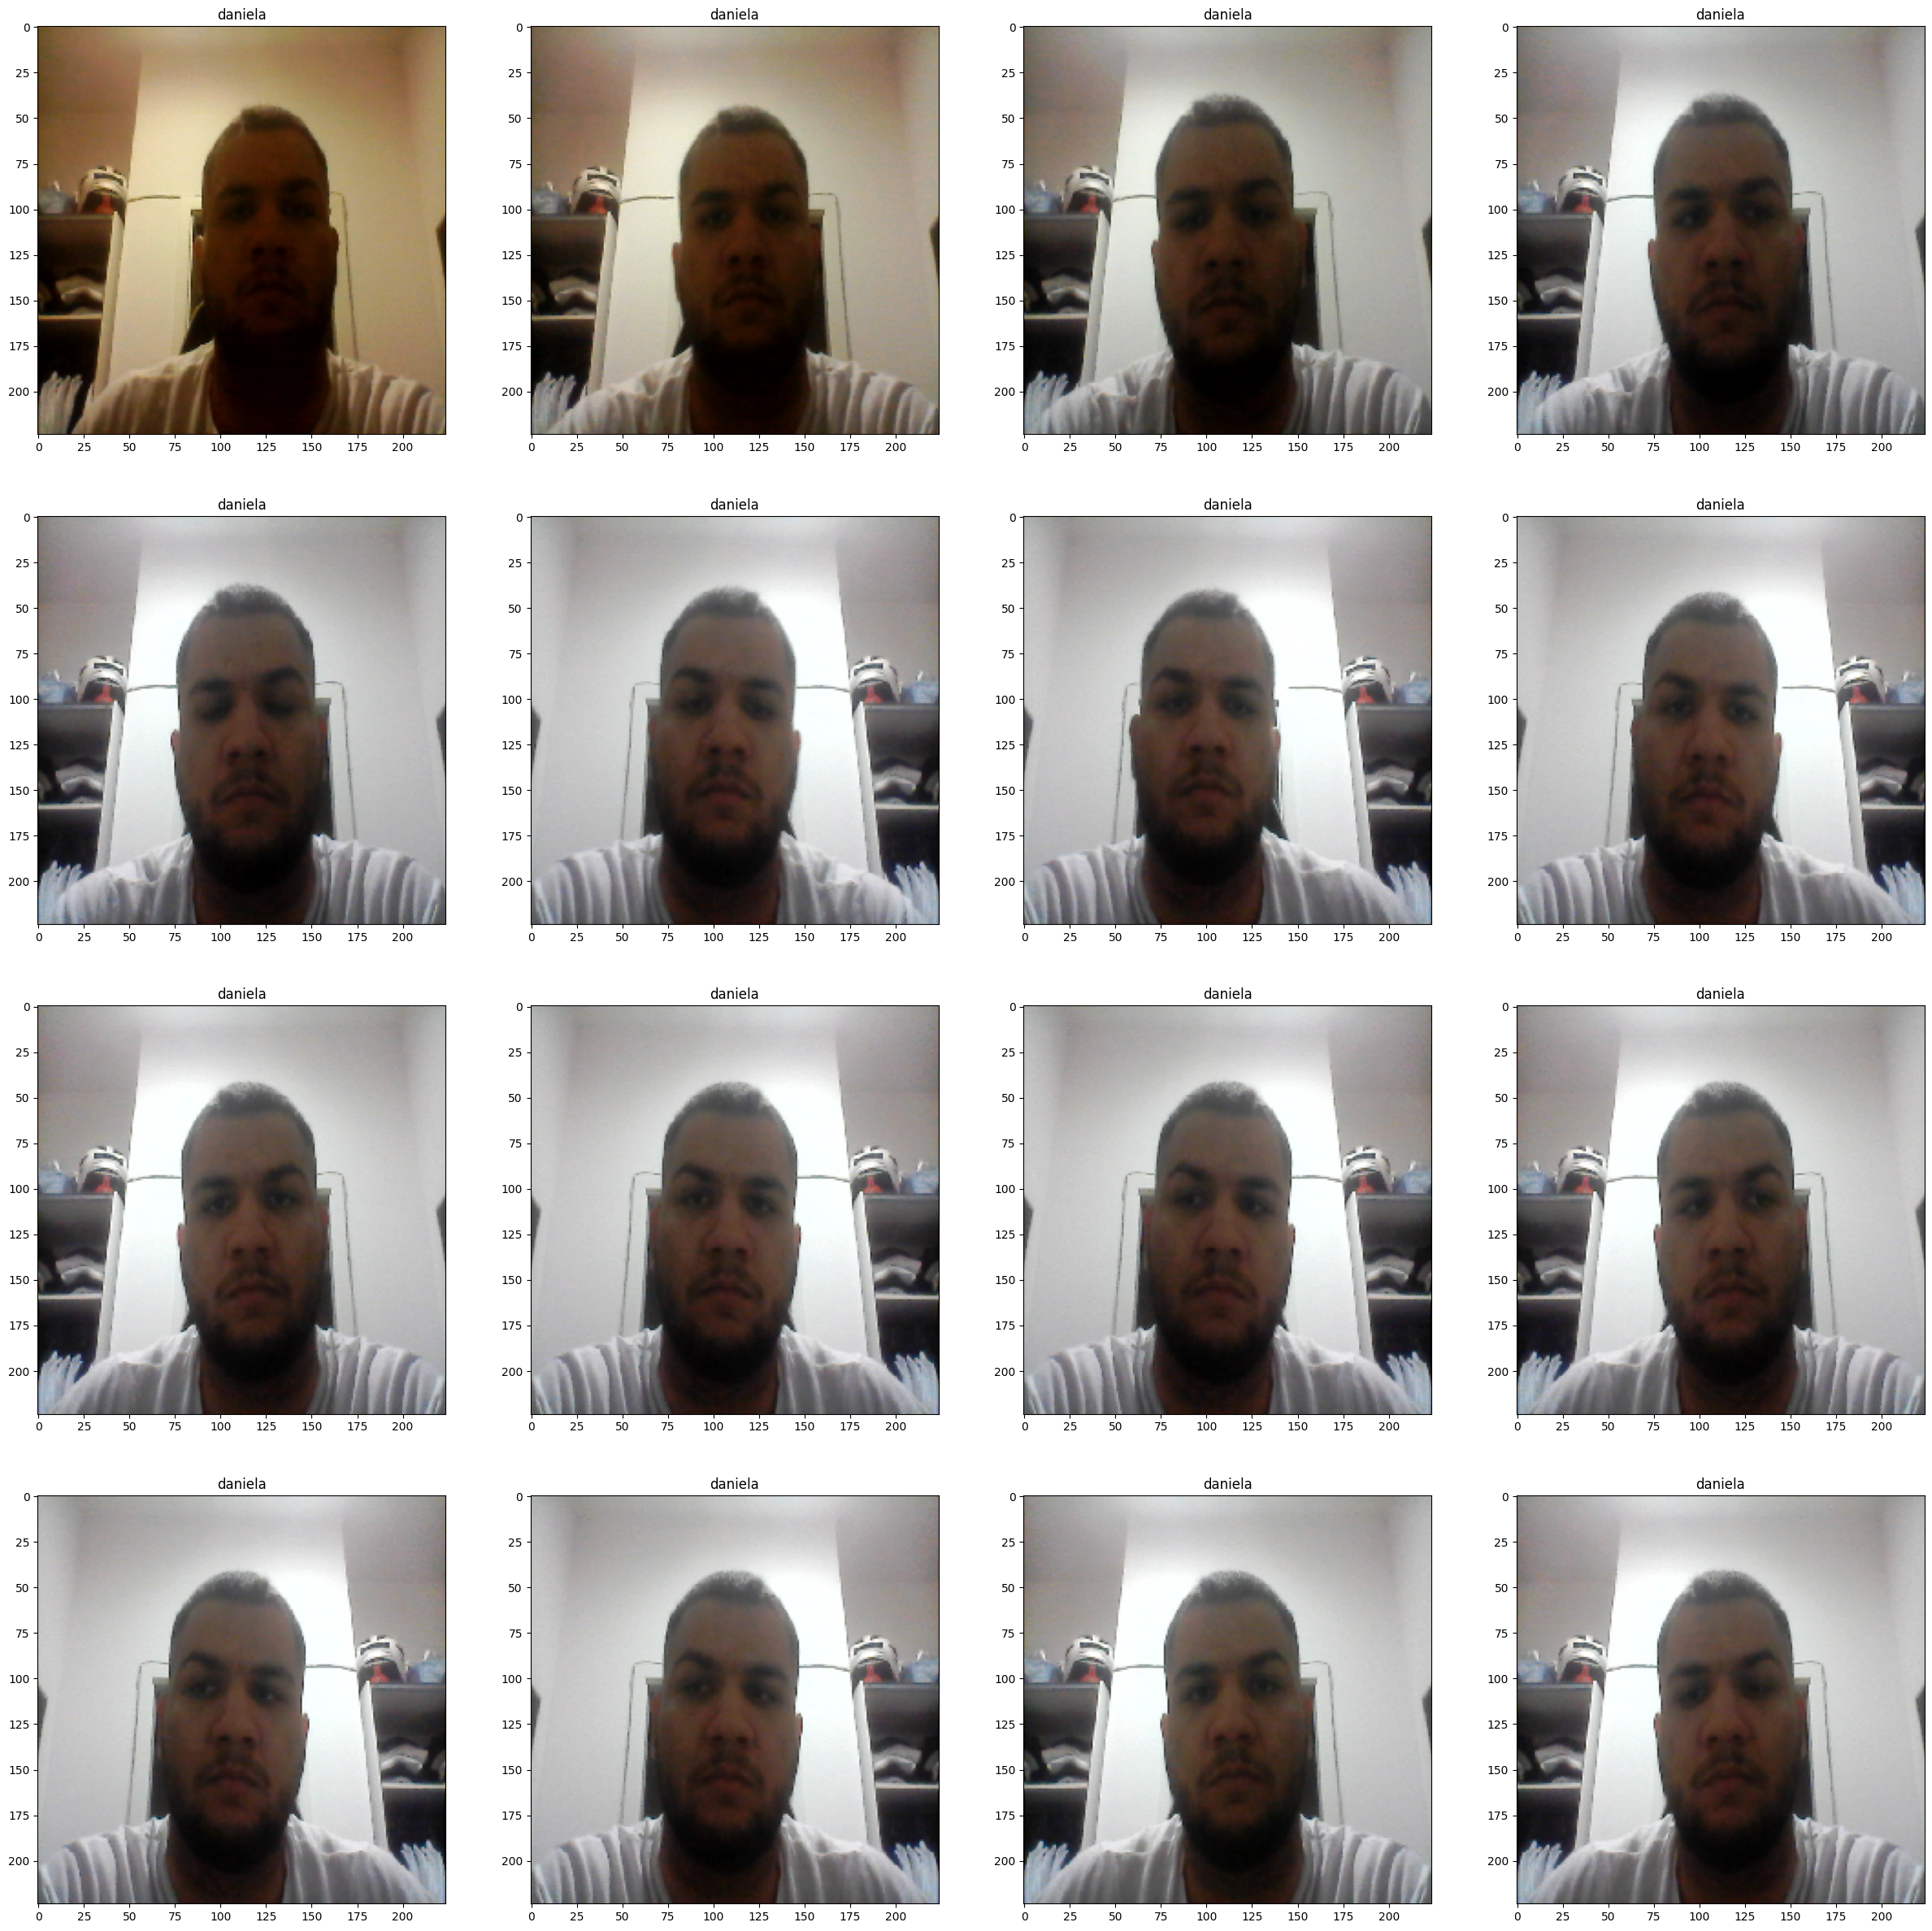

In [12]:
classes=list(Train_Data.class_indices.keys())
plt.figure(figsize=(30,30))
for X_batch, y_batch in Train_Data:
    # create a grid of 7x7 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

## Face model

In [13]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [14]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

model = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13_input (In  [(None, 224, 224, 3)]    0         
 putLayer)                                                       
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                           

## Embeddings

In [ ]:
embedding_vector = model.predict(Train_Data,steps=len(Train_Data), verbose=1)
y_train=Train_Data.labels
np.save('Xdata',embedding_vector)
np.save('ydata',y_train)
embedding_vector = np.load('Xdata.npy')
y_train = np.load('ydata.npy')
embedding_vector[0]
embedding_vector[30]
y_train[0]

## PCA, SVC

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

X_train,X_test,y_train,y_test=train_test_split(embedding_vector,y_train,test_size=0.1,shuffle=True, stratify=y_train,random_state=42)
X_train,y_train = shuffle(X_train,y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=27)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train.shape

clf = SVC(kernel='linear',C=2.,class_weight='balanced',decision_function_shape='ovo',probability=True)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
y_predict[:5]

# Find the classification accuracy
from sklearn.metrics import accuracy_score
print(f'The Accuracy of VGGFace2 is {accuracy_score(y_test,y_predict)*100} %')